<a href="https://colab.research.google.com/github/dajinfx/hanghaeAI2/blob/main/w4_1_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

과제: HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.

모델: microsoft/deberta-base-mnli
test

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import random
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
n_labels = 3
batch_size = 64
max_len = 400
lr = 2e-5
n_epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [4]:
data_ori = load_dataset("nyu-mll/glue", "mnli")
data = data_ori
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
train_dataset = data["train"]
train_dataset[0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

In [6]:
train_df = pd.DataFrame(data["train"])  #과제 요구상 train split 만 사용가능
validation_matched_df = pd.DataFrame(data["validation_matched"])        #과제 요구상 미사용
validation_mismatched_df = pd.DataFrame(data["validation_mismatched"]) #과제 요구상 미사용
test_matched_df = pd.DataFrame(data["test_matched"])                    #과제 요구상 미사용
test_mismatched_df = pd.DataFrame(data["test_mismatched"])              #과제 요구상 미사용

In [7]:
print(train_df.describe(include="all").transpose())
print("------------")
print(train_df["label"].value_counts())

               count  unique         top freq      mean            std  min  \
premise       392702  128144  I blinked.   12       NaN            NaN  NaN   
hypothesis    392702  391501         n/a   40       NaN            NaN  NaN   
label       392702.0     NaN         NaN  NaN   1.00001       0.816499  0.0   
idx         392702.0     NaN         NaN  NaN  196350.5  113363.447042  0.0   

                 25%       50%        75%       max  
premise          NaN       NaN        NaN       NaN  
hypothesis       NaN       NaN        NaN       NaN  
label            0.0       1.0        2.0       2.0  
idx         98175.25  196350.5  294525.75  392701.0  
------------
label
2    130903
1    130900
0    130899
Name: count, dtype: int64


In [8]:
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df["label"])
val_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42, stratify=temp_data["label"])

In [9]:
from datasets import DatasetDict
dataset_dict = {
    'train': train_data,
    'val': val_data,
    'test': test_data,
}


In [10]:
print(len(dataset_dict['train']))
print(len(dataset_dict['val']))
print(len(dataset_dict['test']))

274891
78544
39267


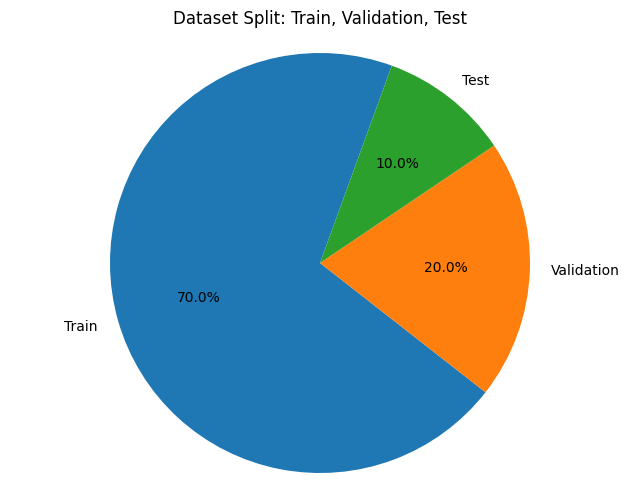

In [11]:
import matplotlib.pyplot as plt

# Mocking dataset lengths as per the discussion since data is no longer available
train_size = len(dataset_dict['train'])
val_size =len(dataset_dict['val'])
test_size = len(dataset_dict['test'])

# Sizes for train, val, and test
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=70)
plt.title("Dataset Split: Train, Validation, Test")
plt.axis('equal')  # Ensure the pie chart is a perfect circle
plt.show()

##Model choose and tokenize

In [12]:
model_name = "microsoft/deberta-base-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
from datasets import Dataset

#Hugging Face Dataset 포멧 전환
train_data = Dataset.from_pandas(train_data)
val_data = Dataset.from_pandas(val_data)
test_data = Dataset.from_pandas(test_data)

In [14]:
# tokenize and embedding
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length")

In [15]:
#train, val, test 전처리
train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)
test_data = test_data.map(preprocess_function, batched=True)


Map:   0%|          | 0/274891 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/78544 [00:00<?, ? examples/s]

Map:   0%|          | 0/39267 [00:00<?, ? examples/s]

In [16]:
train_data

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 274891
})

In [17]:
# "premise"、"hypothesis" 및 "idx" 열을 삭제하는 이유는 데이터 전처리 후 더 이상 필요하지 않기 때문입니다.
#모델은 분할된 특징(예: input_ids 및 attention_mask)과 레이블(label)만 사용하여 학습 및 평가를 수행합니다.
train_dt = train_data.remove_columns(["premise", "hypothesis", "idx"])
val_dt = val_data.remove_columns(["premise", "hypothesis", "idx"])
test_dt = test_data.remove_columns(["premise", "hypothesis", "idx"])

In [18]:
train_dt

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 274891
})

In [ ]:
train_dt['label']

In [20]:
#PyTorch tensor
train_dt.set_format("torch")
val_dt.set_format("torch")
test_dt.set_format("torch")

## Model

In [21]:
print(model.config)  # 모델의 파라미터를 구조 보기

DebertaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/deberta-base-mnli",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "CONTRADICTION",
    "1": "NEUTRAL",
    "2": "ENTAILMENT"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "CONTRADICTION": 0,
    "ENTAILMENT": 2,
    "NEUTRAL": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.47.1",
  "type_vocab_size": 0,
  "vocab_size": 

In [22]:
from transformers import DebertaConfig, AutoModelForSequenceClassification

# 사용자 정의  DeBERTa 매개변수
config = DebertaConfig(
    hidden_size=64,             # layer의 기본 hidden dimension
    intermediate_size=64,       # FFN layer의 중간 hidden dimension
    num_attention_heads=4,      # Multi-head attention에서 사용하는 head 개수
    num_hidden_layers=2,        # 은닉층 수량
    num_labels=3                # 마지막에 예측해야 하는 분류 문제의 class 개수
)

model = AutoModelForSequenceClassification.from_config(config)

In [23]:
print(model.config)

DebertaConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 64,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 64,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 64,
  "pos_att_type": null,
  "position_biased_input": true,
  "relative_attention": false,
  "transformers_version": "4.47.1",
  "type_vocab_size": 0,
  "vocab_size": 50265
}



In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',            # 모델, log 등을 저장할 directory
    num_train_epochs= n_epochs,             # epoch 수
    per_device_train_batch_size=batch_size, # training data의 batch size
    per_device_eval_batch_size=batch_size,  # validation data의 batch size
    logging_strategy="epoch",               # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,                          # 학습을 진행하겠다는 의미
    do_eval=True,                           # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",                  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",                  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=lr,                       # optimizer에 사용할 learning rate
    load_best_model_at_end=True,            # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    report_to="none"
)


## Taining Start

In [26]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [28]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dt,
    eval_dataset=val_dt,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

<ipython-input-28-7cb3523e7910>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.094200,1.075810,0.409414
2,1.043200,1.024241,0.475173
3,1.010100,1.006363,0.493927
4,0.991100,0.997849,0.505067
5,0.979400,0.994330,0.506111
6,0.969800,0.993566,0.508581
7,0.962000,0.993467,0.509205
8,0.956000,0.995040,0.510376
9,0.952100,0.995558,0.510147
10,0.949000,0.996164,0.509523


TrainOutput(global_step=42960, training_loss=0.9907005210606523, metrics={'train_runtime': 1831.4296, 'train_samples_per_second': 1500.964, 'train_steps_per_second': 23.457, 'total_flos': 94787303615676.0, 'train_loss': 0.9907005210606523, 'epoch': 10.0})

In [30]:
trainer.evaluate(test_dt)

{'eval_loss': 0.9904545545578003,
 'eval_accuracy': 0.5113199378613085,
 'eval_runtime': 14.1426,
 'eval_samples_per_second': 2776.505,
 'eval_steps_per_second': 43.415,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [31]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [36]:
def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []
    val_precision = []
    val_recall = []

    # 로그 데이터 분리
    for log in log_history:
        print(log)

plotting()

{'loss': 1.0942, 'grad_norm': 1.313510537147522, 'learning_rate': 1.8e-05, 'epoch': 1.0, 'step': 4296}
{'eval_loss': 1.0758100748062134, 'eval_accuracy': 0.40941383173762474, 'eval_runtime': 28.5203, 'eval_samples_per_second': 2753.967, 'eval_steps_per_second': 43.057, 'epoch': 1.0, 'step': 4296}
{'loss': 1.0432, 'grad_norm': 4.178253650665283, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0, 'step': 8592}
{'eval_loss': 1.0242408514022827, 'eval_accuracy': 0.4751731513546547, 'eval_runtime': 29.0756, 'eval_samples_per_second': 2701.374, 'eval_steps_per_second': 42.235, 'epoch': 2.0, 'step': 8592}
{'loss': 1.0101, 'grad_norm': 3.627851724624634, 'learning_rate': 1.4e-05, 'epoch': 3.0, 'step': 12888}
{'eval_loss': 1.0063632726669312, 'eval_accuracy': 0.49392697086983095, 'eval_runtime': 27.7342, 'eval_samples_per_second': 2832.026, 'eval_steps_per_second': 44.277, 'epoch': 3.0, 'step': 12888}
{'loss': 0.9911, 'grad_norm': 3.7331326007843018, 'learning_rate': 1.2e-05, 'epoch': 4.0, 

##[My Code]
추출한 모델 및 Log 저장 Download

In [37]:
import os
print(os.getcwd())

/content


In [38]:
import os
print(os.listdir())

['.config', 'results', 'sample_data']


In [41]:
hf_huggingface = os.path.abspath("./results")
print(hf_huggingface)

/content/results


In [42]:
import shutil
shutil.make_archive("hf_huggingface", "zip", "/content/results")

'/content/hf_huggingface.zip'

In [45]:
from google.colab import files
files.download("hf_huggingface.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>